In [41]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from keras import metrics

In [42]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [45]:
Column_List = ["word"]
Label_Col = "Label"
Vector_Size = 13
Feature_Cols = ["POS", "POS_Prev", "POS_Next", "Hedge", "Hedge_Context", "Factive", "Factive_Context", "Assertive", "Assertive_Context",
                  "Implicative", "Implicative_Context", "Report", "Report_Context", 
                   "Entailment", "Entailment_Context", "StrongSub", "StrongSub_Context", 
                   "WeakSub", "WeakSub_Context", "Polarity", "Positive", "Positive_Context", 
                   "Negative", "Negative_Context", "Bias_Lexicon"]

FeatureList = ["POS", "Hedge", "Factive", "Assertive", "Implicative", "Report", "Entailment", "StrongSub", 
               "WeakSub", "Polarity", "Positive", "Negative", "Bias_Lexicon"]
Column_List.extend(Feature_Cols)
Column_List.append(Label_Col)

Folder_Path = "/Users/pranjali/Downloads/Wiki_BiasDetection/Data/Task2_FinalData/"

Train_Features_FilePath = Folder_Path + "Wiki_LiguisticFeatures_Train.csv"
Test_Features_FilePath = Folder_Path + "Wiki_LiguisticFeatures_Test.csv"
NN_Model_FilePath = "/Users/pranjali/Downloads/Wiki_BiasDetection/Saved_Models/Task2_NN_Trained_Model.pkl"

train_data = pd.read_csv(Train_Features_FilePath, usecols=Column_List)
test_data = pd.read_csv(Test_Features_FilePath, usecols=Column_List)

In [46]:
train_df, val_df = train_test_split(train_data, test_size=0.2)
test_df = test_data

In [47]:
# Form np arrays of labels and features.
train_labels = np.array(train_df['Label'])
bool_train_labels = train_labels != 0
val_labels = np.array(val_df['Label'])
test_labels = np.array(test_df['Label'])

train_features = np.array(train_df[Feature_Cols])
val_features = np.array(val_df[Feature_Cols])
test_features = np.array(test_df[Feature_Cols])

In [48]:
# scaler = StandardScaler()
# train_features = scaler.fit_transform(train_features)

# val_features = scaler.transform(val_features)
# test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)


Training labels shape: (408373,)
Validation labels shape: (102094,)
Test labels shape: (199992,)
Training features shape: (408373, 25)
Validation features shape: (102094, 25)
Test features shape: (199992, 25)


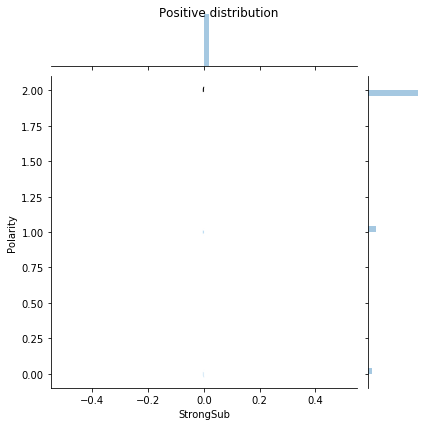

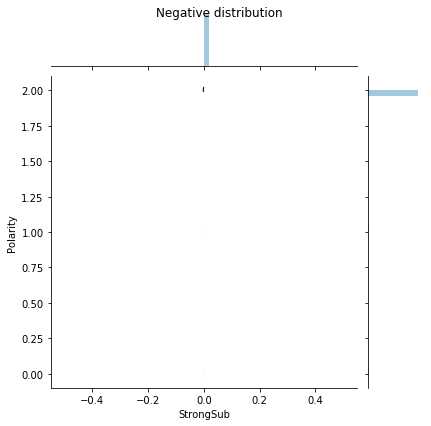

In [50]:
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns = Feature_Cols)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns = Feature_Cols)

# sns.jointplot(pos_df['POS_Prev'], pos_df['Polarity'],
#               kind='hex', xlim = (-5,5), ylim = (-5,5))
# plt.suptitle("Positive distribution")

# sns.jointplot(neg_df['POS_Prev'], neg_df['Polarity'],
#               kind='hex', xlim = (-5,5), ylim = (-5,5))
# _ = plt.suptitle("Negative distribution")

sns.jointplot(pos_df['StrongSub'], pos_df['Polarity'],
              kind='hex')
plt.suptitle("Positive distribution")

sns.jointplot(neg_df['StrongSub'], neg_df['Polarity'],
              kind='hex')
_ = plt.suptitle("Negative distribution")

In [51]:
# val_auc = metrics.AUC()

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
#       val_auc    
]

def make_model(metrics = METRICS, output_bias=None):
    
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
        
    model = keras.Sequential([ keras.layers.Dense(16, activation='relu',input_shape=(train_features.shape[-1],)),
                              keras.layers.Dropout(0.5), keras.layers.Dense(1, activation='sigmoid',
                                                                            bias_initializer=output_bias),])
    
    model.compile( optimizer=keras.optimizers.Adam(lr=1e-3), loss=keras.losses.BinaryCrossentropy(), metrics=metrics)

    return model


In [52]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='recall', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [53]:
model = make_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 16)                416       
_________________________________________________________________
dropout_7 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 17        
Total params: 433
Trainable params: 433
Non-trainable params: 0
_________________________________________________________________


In [54]:
model.predict(train_features[:10])

array([[0.36985433],
       [0.36985433],
       [0.36985433],
       [0.36985433],
       [0.36985433],
       [0.3051582 ],
       [0.36985433],
       [0.38037598],
       [0.3698543 ],
       [0.37944245]], dtype=float32)

In [55]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.5214


In [56]:
neg, pos = np.bincount(train_df['Label'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

initial_bias = np.log([pos/neg])
initial_bias

Examples:
    Total: 408373
    Positive: 48712 (11.93% of total)



array([-1.99923651])

In [57]:
model = make_model(output_bias = initial_bias)
model.predict(train_features[:10])

array([[0.21319535],
       [0.21319535],
       [0.21319535],
       [0.21319535],
       [0.21319535],
       [0.07201546],
       [0.21319535],
       [0.18915704],
       [0.21319531],
       [0.13297091]], dtype=float32)

In [58]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.3915


In [59]:
initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
model.save_weights(initial_weights)


Consider using a TensorFlow optimizer from `tf.train`.


In [60]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [61]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [62]:
def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
    plt.semilogy(history.epoch,  history.history['loss'],
               color=colors[n], label='Train '+label)
    plt.semilogy(history.epoch,  history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
  
    plt.legend()

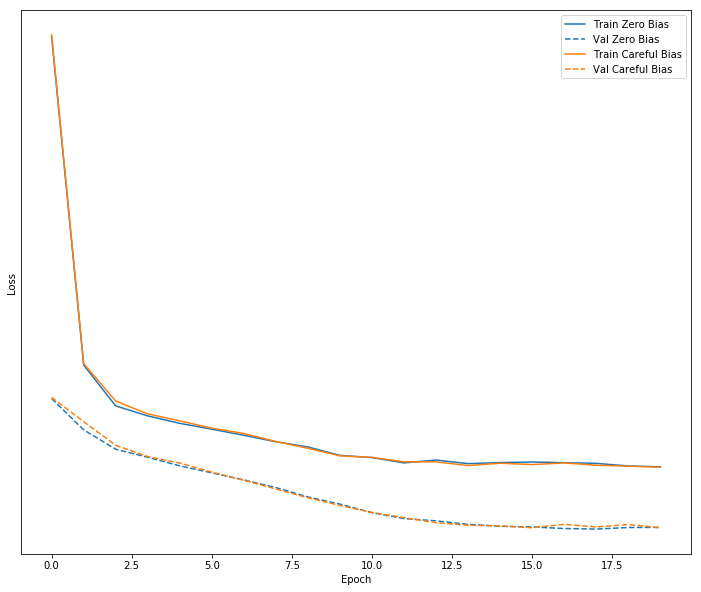

In [63]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

In [64]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_features, val_labels))

Train on 408373 samples, validate on 102094 samples
Epoch 1/100
408373/408373 [==============================] - 5s 12us/sample - loss: 0.3937 - tp: 454.0000 - fp: 3536.0000 - tn: 356125.0000 - fn: 48258.0000 - accuracy: 0.8732 - precision: 0.1138 - recall: 0.0093 - val_loss: 0.3648 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 90038.0000 - val_fn: 12056.0000 - val_accuracy: 0.8819 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
408373/408373 [==============================] - 2s 5us/sample - loss: 0.3676 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 359661.0000 - fn: 48712.0000 - accuracy: 0.8807 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.3628 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 90038.0000 - val_fn: 12056.0000 - val_accuracy: 0.8819 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
408373/408373 [==============================] - 2s 5us/sample - loss: 0.3645 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 359661.0000 - fn: 48712.

In [65]:
def plot_metrics(history):
    metrics =  ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
    if metric == 'loss':
        plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
        plt.ylim([0.8,1])
    else:
        plt.ylim([0,1])

    plt.legend()


KeyError: 'auc'

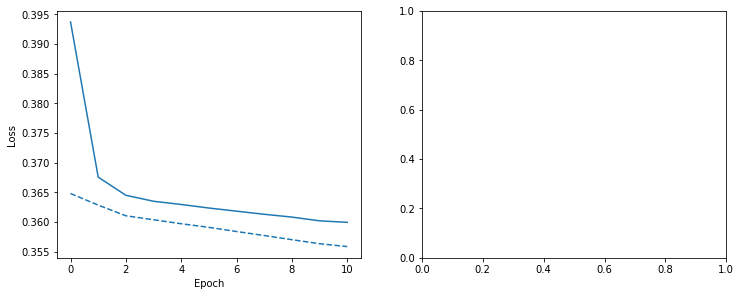

In [66]:
plot_metrics(baseline_history)

In [67]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

In [68]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))

loss :  0.43825613775703065
tp :  0.0
fp :  0.0
tn :  169096.0
fn :  30896.0
accuracy :  0.8455138
precision :  0.0
recall :  0.0

Legitimate Transactions Detected (True Negatives):  169096
Legitimate Transactions Incorrectly Detected (False Positives):  0
Fraudulent Transactions Missed (False Negatives):  30896
Fraudulent Transactions Detected (True Positives):  0
Total Fraudulent Transactions:  30896


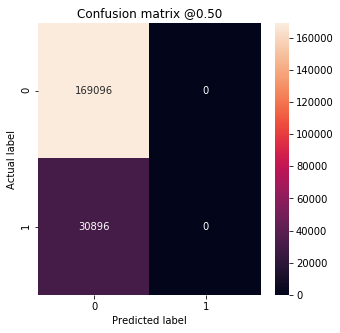

In [69]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)